In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

df = pd.read_csv("/kaggle/input/grocery-store-sales-dataset-in-2025-1900-record/grocery_chain_data.csv")
df.head()


,customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
0,2824,GreenGrocer Plaza,2023-08-26,Produce,Pasta,2.0,7.46,14.92,0.00,14.92,377
1,5506,ValuePlus Market,2024-02-13,Dairy,Cheese,1.0,1.85,1.85,3.41,-1.56,111
2,4657,ValuePlus Market,2023-11-23,Bakery,Onions,4.0,7.38,29.52,4.04,25.48,301
3,2679,SuperSave Central,2025-01-13,Snacks & Candy,Cereal,3.0,5.50,16.50,1.37,15.13,490
4,9935,GreenGrocer Plaza,2023-10-13,Canned Goods,Orange Juice,5.0,8.66,43.30,1.50,41.80,22


In [15]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
daily_sales = df.groupby(['transaction_date','product_name'])['quantity'].sum().reset_index()
sales_pivot = daily_sales.pivot(index='transaction_date', columns='product_name', values='quantity').fillna(0)
sales_pivot.head()


product_name,Apples,Bananas,Bread,Carrots,Cereal,Cheese,Chicken Breast,Eggs,Ground Beef,Milk,Onions,Orange Juice,Pasta,Potatoes,Rice,Salmon,Tomatoes,Yogurt
transaction_date,,,,,,,,,,,,,,,,,,
2023-08-07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2023-08-08,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-08-11,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-12,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2023-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [16]:
n_lags = 3
features = sales_pivot.copy()
for lag in range(1, n_lags + 1):
    lagged = sales_pivot.shift(lag)
    lagged.columns = [f"{col}_lag{lag}" for col in sales_pivot.columns]
    features = pd.concat([features, lagged], axis=1)
features = features.dropna()
target = sales_pivot.shift(-1).loc[features.index]
features.head()
target.head()


product_name,Apples,Bananas,Bread,Carrots,Cereal,Cheese,Chicken Breast,Eggs,Ground Beef,Milk,Onions,Orange Juice,Pasta,Potatoes,Rice,Salmon,Tomatoes,Yogurt
transaction_date,,,,,,,,,,,,,,,,,,
2023-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2023-08-13,0.0,3.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2023-08-14,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2023-08-16,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2023-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
split_idx = int(len(features)*0.8)
X_train, X_test = features.iloc[:split_idx], features.iloc[split_idx:]
y_train, y_test = target.iloc[:split_idx], target.iloc[split_idx:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(X_train, y_train)

y_pred = multi_rf.predict(X_test)
rmse_per_product = np.sqrt(((y_test - y_pred)**2).mean())
print("RMSE per product:")
print(rmse_per_product)


RMSE per product:
product_name
Apples            1.598566
Bananas           1.240697
Bread             1.595093
Carrots           1.539172
Cereal            1.258779
Cheese            1.332253
Chicken Breast    1.338374
Eggs              1.379121
Ground Beef       1.361687
Milk              1.409813
Onions            1.080277
Orange Juice      1.471150
Pasta             1.251727
Potatoes          1.510203
Rice              1.401924
Salmon            1.403183
Tomatoes          1.390400
Yogurt            1.552664
dtype: float64


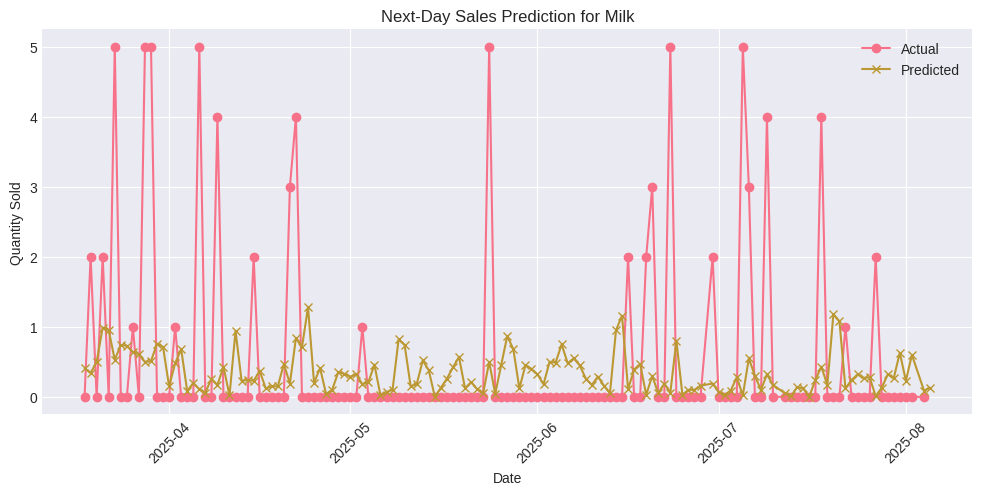

In [18]:
product = 'Milk'
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test[product], label='Actual', marker='o')
plt.plot(y_test.index, y_pred[:, y_test.columns.get_loc(product)], label='Predicted', marker='x')
plt.title(f'Next-Day Sales Prediction for {product}')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [19]:
# ================================================
# Step 6 — Performance metrics with NaN handled
# ================================================

from sklearn.metrics import mean_absolute_error, r2_score

# Drop rows with NaN in y_test or y_pred
y_test_clean = y_test.dropna()
y_pred_clean = y_pred[:len(y_test_clean)]  # align predictions with cleaned target

mae_per_product = mean_absolute_error(y_test_clean, y_pred_clean, multioutput='raw_values')
r2_per_product = r2_score(y_test_clean, y_pred_clean, multioutput='raw_values')

print("MAE per product:", mae_per_product)
print("R2 per product:", r2_per_product)


MAE per product: [0.94729927 0.77489051 0.93051095 0.75693431 0.77350365 0.7680292
 0.80510949 0.77547445 0.71934307 0.7929927  0.72985401 0.82912409
 0.73934307 0.83379562 0.78956204 0.83759124 0.85576642 0.89452555]
R2 per product: [-0.1814593  -0.12506555 -0.29965141 -0.11089523 -0.11160747 -0.2995653
 -0.21634885 -0.22379747 -0.23295292 -0.073765   -0.42470465 -0.05818011
 -0.12431819 -0.13993216 -0.19087082 -0.06953932 -0.1024687  -0.085857  ]


In [20]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
rmse_list = []

for train_idx, test_idx in tscv.split(features):
    X_tr, X_te = features.iloc[train_idx], features.iloc[test_idx]
    y_tr, y_te = target.iloc[train_idx], target.iloc[test_idx]
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    model.fit(X_tr, y_tr)
    y_pred_cv = model.predict(X_te)
    rmse_list.append(np.sqrt(((y_te - y_pred_cv)**2).mean()).mean())

print("Average RMSE across folds:", np.mean(rmse_list))


Average RMSE across folds: 1.3726042096876323
